In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.leaguehustlestatsteam import LeagueHustleStatsTeam
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes

In [4]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick

zoom = 0.1
team_root_dir = '../../team_logos_id/'

def get_player_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [5]:
plt.style.use('fivethirtyeight')

## Contested shots

In [6]:
hustle_stats = LeagueHustleStatsTeam(season='2021-22', per_mode_time='PerGame').get_data_frames()[0]

## Shooting fouls

In [10]:
full_df = pd.read_csv('pbp_data/2021-22.csv')

In [11]:
full_df = pd.read_csv('pbp_data/2021-22.csv')

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [12]:
full_df

,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESECONDS,PCTIMESTRING,PERIOD,PERSON1TYPE,...,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VIDEO_AVAILABLE_FLAG,VISITORDESCRIPTION,WCTIMESTRING
0,0,12,2,0022100239,,Start of 1st Period (5:12 PM EST),0,12:00,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,,5:12 PM
1,0,10,4,0022100239,Jump Ball Robinson vs. Wood: Tip to Fournier,,0,12:00,1,4,...,Evan Fournier,NYK,New York,1.610613e+09,Knicks,NaN,NaN,1,,5:12 PM
2,6,2,7,0022100239,MISS Barrett 2' Driving Layup,,17,11:43,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,,5:13 PM
3,0,4,8,0022100239,,,19,11:41,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Theis REBOUND (Off:0 Def:1),5:13 PM
4,1,2,9,0022100239,,,36,11:24,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MISS Gordon 24' 3PT Jump Shot,5:13 PM
5,0,4,10,0022100239,,,38,11:22,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Green REBOUND (Off:1 Def:0),5:13 PM
6,1,5,11,0022100239,Fournier STEAL (1 STL),,44,11:16,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Green Bad Pass Turnover (P1.T1),5:13 PM
7,63,2,13,0022100239,MISS Randle 9' Fadeaway Jumper,,51,11:09,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,,5:13 PM
8,0,4,14,0022100239,,,53,11:07,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Wood REBOUND (Off:0 Def:1),5:13 PM
9,45,5,15,0022100239,,,61,10:59,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Gordon Out of Bounds - Bad Pass Turnover Turno...,5:13 PM


In [13]:
shooting_fouls = full_df.loc[(full_df.EVENTMSGTYPE == 6) & (full_df.EVENTMSGACTIONTYPE == 2)]

#### Merging data

In [14]:
total_fouls = []

for team_id in hustle_stats.TEAM_ID.unique().tolist():
    team_fouls = shooting_fouls.loc[shooting_fouls.PLAYER1_TEAM_ID == team_id]
    team_games = len(full_df.loc[full_df.PLAYER1_TEAM_ID == team_id].GAME_ID.unique())
    total_fouls.append(len(team_fouls) / team_games)

In [15]:
hustle_stats.loc[:, 'SHOOTING_FOULS_PER_G'] = total_fouls

Text(10, 42.75, 'source: nba.com')

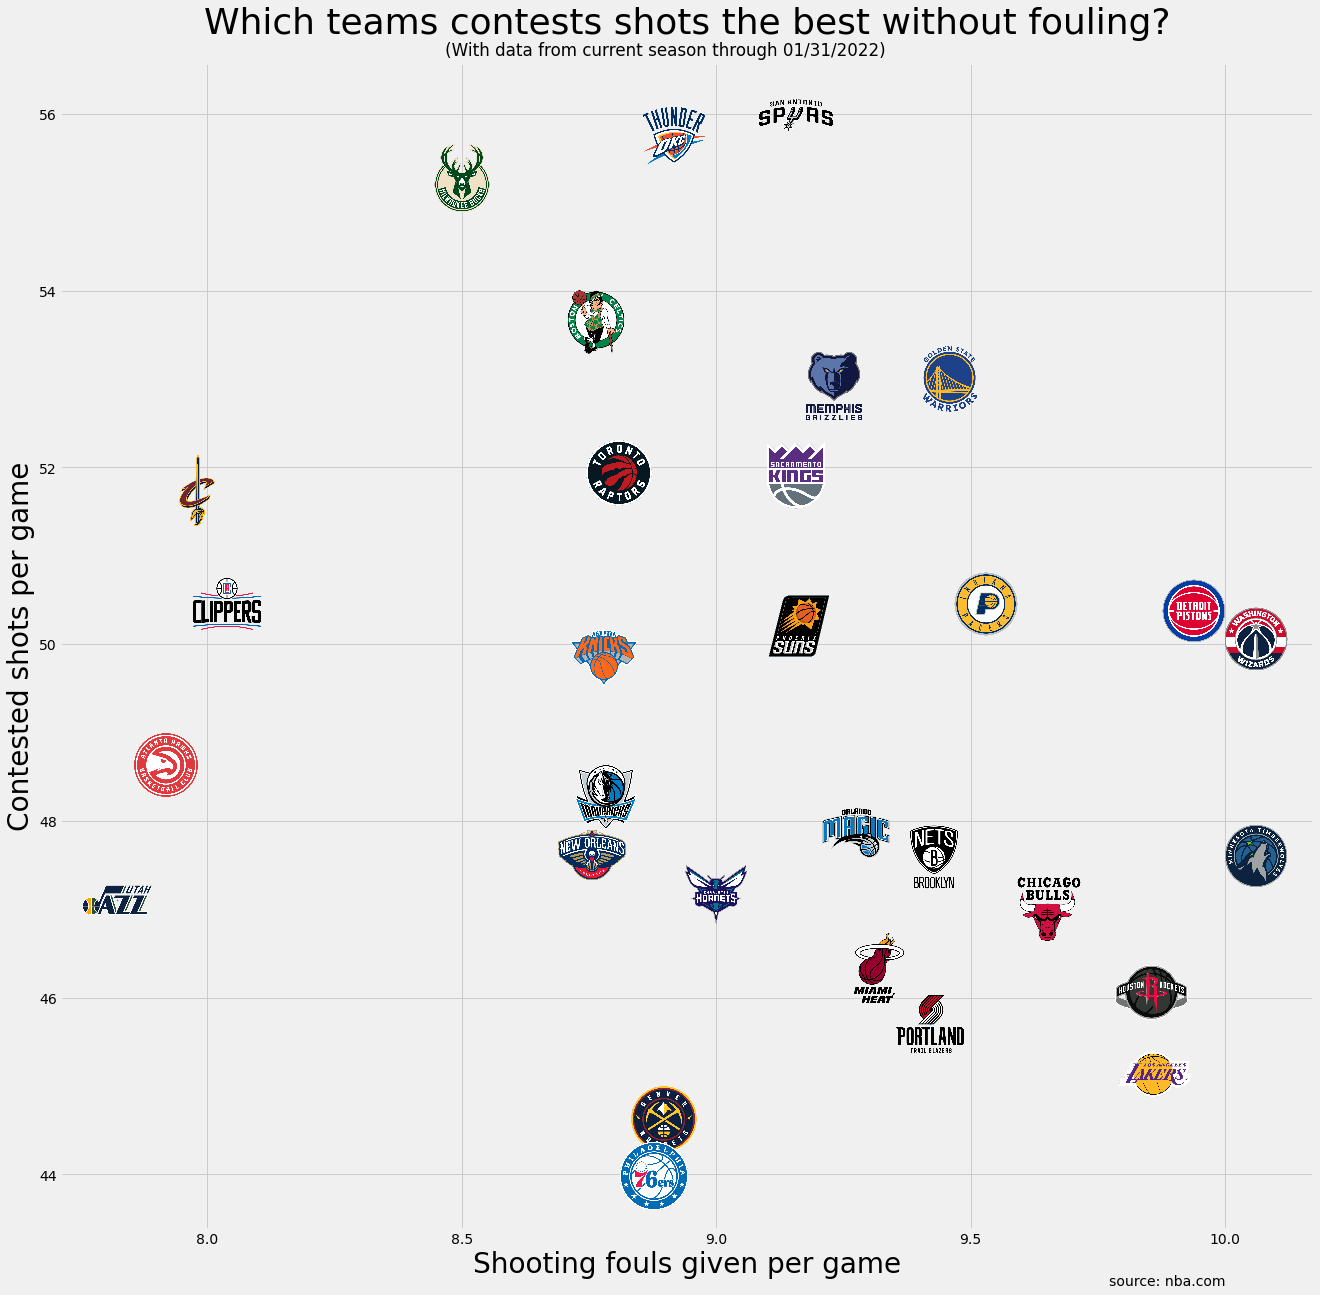

In [29]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(hustle_stats.SHOOTING_FOULS_PER_G, hustle_stats.CONTESTED_SHOTS, s=1)

for i in range(len(hustle_stats)):
    item = hustle_stats.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID), (item.SHOOTING_FOULS_PER_G, item.CONTESTED_SHOTS), frameon=False)
    ax.add_artist(ab)
    

ax.set_ylabel("Contested shots per game", size=28)
ax.set_xlabel("Shooting fouls given per game", size=28)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title("Which teams contests shots the best without fouling?", size=36, y=1.02)
plt.suptitle("(With data from current season through 01/31/2022)", y=0.895)
ax.text(x=10, y=42.75, s='source: nba.com', ha='right')